In [13]:
import requests
import pandas as pd
import time
from langdetect import detect

# --- Twitter API Setup ---
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAKEq1wEAAAAAYhfmwZJz856UCB5qRAsJSL3e6YA%3De3nuxkHSWfEFpuUZ9wTnM9EdvuhOXXRdnfRJsyuXOuPkpfavyw'
headers = {'Authorization': f'Bearer {BEARER_TOKEN}'}
search_url = 'https://api.twitter.com/2/tweets/search/recent'

# --- Query Parameters ---
query = '(transport OR fare OR public transport) Rwanda'
params = {
    'query': query,
    'max_results': 100,
    'tweet.fields': 'created_at,text,author_id,lang'
}

all_tweets = []
next_token = None

# --- Fetch Tweets with Pagination and Retry ---
for _ in range(10):  # up to ~1000 tweets
    if next_token:
        params['next_token'] = next_token

    response = requests.get(search_url, headers=headers, params=params)

    if response.status_code == 429:
        print("Rate limit hit. Waiting 15 minutes...")
        time.sleep(15 * 60)
        continue

    result = response.json()

    if 'data' in result:
        all_tweets.extend(result['data'])
    else:
        print("No data returned:", result)
        break

    next_token = result.get('meta', {}).get('next_token')
    if not next_token:
        break

    time.sleep(1)

# --- Convert to DataFrame ---
df = pd.DataFrame(all_tweets)

if df.empty:
    print("No tweets collected.")
else:
    # --- Language Filtering ---
    df["lang"] = df["text"].apply(lambda x: detect(x) if isinstance(x, str) else "unknown")
    df = df[df["lang"] == "en"]

    # --- Cleanup and Save ---
    df.rename(columns={'created_at': 'date', 'author_id': 'user'}, inplace=True)
    df = df[["date", "user", "text"]]
    df.to_csv("data/expanded_tweets.csv", index=False)
    print(f"✅ Saved {len(df)} English tweets to data/expanded_tweets.csv")

    print(df.head())


✅ Saved 89 English tweets to data/expanded_tweets.csv
                       date                 user  \
0  2025-05-17T07:25:50.000Z  1393937647203143684   
1  2025-05-17T03:15:26.000Z            754543548   
2  2025-05-16T17:24:14.000Z   765177385545269248   
3  2025-05-16T14:15:53.000Z  1563181541529772033   
4  2025-05-16T14:10:30.000Z            517594178   

                                                text  
0  @Ibuka_Rwanda @NgomaDistrict @Unity_MemoryRw @...  
1  Rwanda’s fast rate of development and their am...  
2  RT @_Yanoh: The way Kagame talks you wouldn't ...  
3  RT @_Yanoh: The way Kagame talks you wouldn't ...  
4  RT @_Yanoh: The way Kagame talks you wouldn't ...  


                 date                 user  \
0 2025-05-17 07:25:50  1393937647203143684   
1 2025-05-17 03:15:26            754543548   
2 2025-05-16 17:24:14   765177385545269248   
3 2025-05-16 14:15:53  1563181541529772033   
4 2025-05-16 14:10:30            517594178   

                                                text sentiment  
0  @Ibuka_Rwanda @NgomaDistrict @Unity_MemoryRw @...   Neutral  
1  Rwanda’s fast rate of development and their am...  Positive  
2  RT @_Yanoh: The way Kagame talks you wouldn't ...  Negative  
3  RT @_Yanoh: The way Kagame talks you wouldn't ...  Negative  
4  RT @_Yanoh: The way Kagame talks you wouldn't ...  Negative  


<Figure size 1000x600 with 0 Axes>

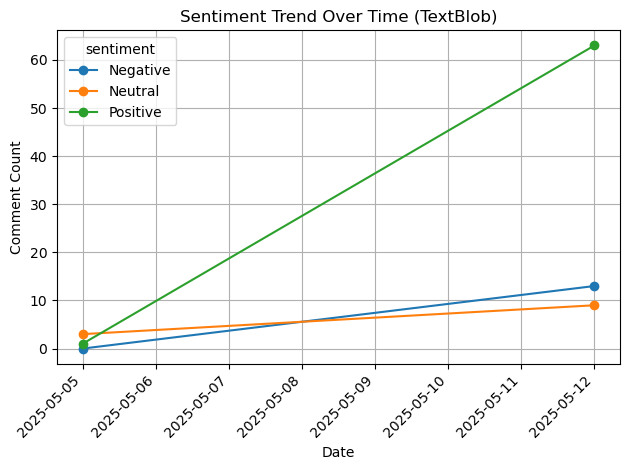

In [17]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("data/expanded_tweets.csv")

# Apply sentiment analysis using TextBlob
def classify_sentiment_blob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.05:
        return "Positive"
    elif polarity <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["text"].apply(classify_sentiment_blob)

# Parse date and remove timezone info
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

# Group by week and sentiment
sentiment_over_time = df.groupby([df["date"].dt.to_period("W"), "sentiment"]).size().unstack(fill_value=0)
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

# OPTIONAL: Preview the processed data
print(df.head())

# Plot sentiment trend
plt.figure(figsize=(10, 6))
sentiment_over_time.plot(marker='o')
plt.title("Sentiment Trend Over Time (TextBlob)")
plt.xlabel("Date")
plt.ylabel("Comment Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
